In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu



In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outdir_fig = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 8748 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_138427/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_138427/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [10]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [11]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [12]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

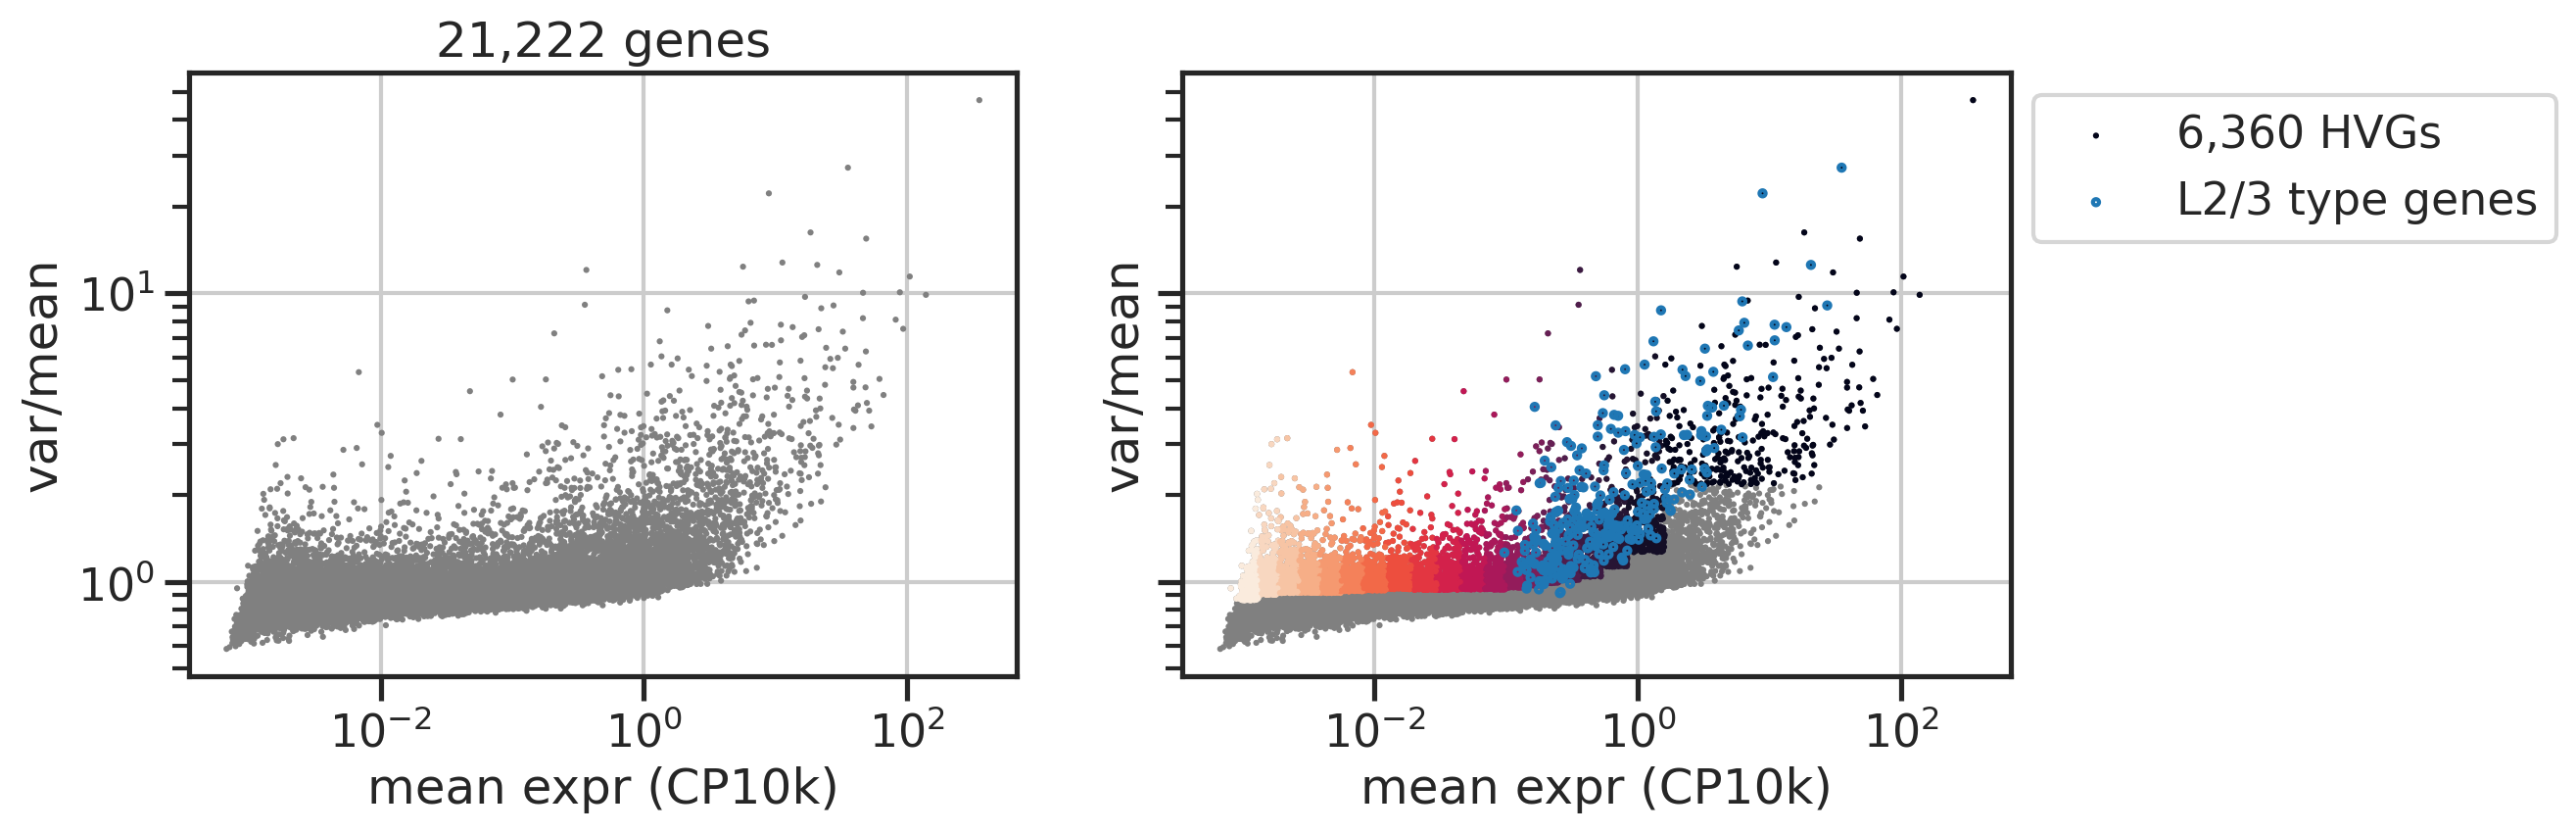

In [13]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [15]:
# adata = adata_sub[:,gsel_idx]
adata = adata_sub[:,l23_gidx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 8748 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [16]:
adata_nr = adata[adata.obs['cond']=='P28NR']
# adata_nr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_1']
# adata_nr1a = adata[adata.obs['sample']=='P28_1a']
# adata_nr1b = adata[adata.obs['sample']=='P28_1b']
# adata_nr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_2']

adata_dr = adata[adata.obs['cond']=='P28DR']
# adata_dr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_1']
# adata_dr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_3']

adata_dr #, adata_dr, adata_nr1, adata_nr2, adata_dr1, adata_dr2

View of AnnData object with n_obs × n_vars = 4704 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [17]:
def pca_pipe(adata):
    
    np.random.seed(0)
    pca = PCA(n_components=10)
    
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    zlognorm = np.nan_to_num(zlognorm, 0)
    
    pcs = pca.fit_transform(zlognorm) # auto centering
    
    return zlognorm-np.mean(zlognorm, axis=0), pca, pcs # manual centering


In [18]:
X_nr, pca_nr, pcs_nr = pca_pipe(adata_nr)
V_nr = pca_nr.components_.T

X_dr, pca_dr, pcs_dr = pca_pipe(adata_dr)

In [19]:
X_nr.shape, pcs_nr.shape, V_nr.shape, np.all(X_nr.dot(V_nr) - pcs_nr < 1e-4)

((4044, 286), (4044, 10), (286, 10), False)

In [20]:
df_nr = adata_nr.obs.join(pd.DataFrame(pcs_nr, index=adata_nr.obs.index, columns=np.char.add("PC", (1+np.arange(pcs_nr.shape[1])).astype(str))))
df_nr

,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AAACCCAGTTCTCTCG-1-P28_1a-P28,Excitatory,False,0.040816,P28,6,16814.0,4895,0.002141,P28_1a,L2/3_C,...,1.146310,5.234220,-2.200650,-3.930139,-0.109692,1.076847,2.164270,-0.138780,0.979746,-0.652572
AAACGAAAGCAAGGAA-1-P28_1a-P28,Excitatory,False,0.014196,P28,0,15174.0,4464,0.000132,P28_1a,L2/3_B,...,-0.518836,-6.410187,1.400580,0.048699,-0.776734,-3.167177,-0.375505,-1.615023,0.152334,1.824171
AAACGCTAGTTTGCTG-1-P28_1a-P28,Excitatory,False,0.071146,P28,6,14503.0,4361,0.000483,P28_1a,L2/3_C,...,3.927444,3.636513,-1.235004,-2.777096,-0.595846,-0.813365,-0.309820,-0.609142,-0.297808,-0.032245
AAACGCTCAACCGTGC-1-P28_1a-P28,Excitatory,False,0.102461,P28,6,21649.0,5520,0.000878,P28_1a,L2/3_C,...,11.051366,6.327099,2.315227,1.087544,-1.127316,-2.495627,1.611443,-0.660253,1.596810,-1.532568
AAAGAACAGCGATGGT-1-P28_1a-P28,Excitatory,False,0.026695,P28,0,5535.0,2633,0.000542,P28_1a,L2/3_B,...,-3.685946,-2.021656,-0.265279,-2.169408,0.286824,-1.522951,1.073753,-2.415270,-1.669591,-2.367530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTAACAAGT-1-P28_2b-P28,Excitatory,False,0.020575,P28,0,12070.0,3374,0.000497,P28_2b,L2/3_B,...,-6.097827,-2.068488,-1.280441,1.154931,-1.459297,0.581308,0.536674,-1.790616,2.694780,-1.182084
TTTCGATTCCGCTAGG-1-P28_2b-P28,Excitatory,False,0.029584,P28,0,14473.0,4228,0.000345,P28_2b,L2/3_B,...,-3.879909,0.587705,1.844373,-2.059884,1.109426,-1.935744,-1.607946,1.964970,-1.482029,-0.330953
TTTGACTTCAGCTTGA-1-P28_2b-P28,Excitatory,False,0.020575,P28,0,14007.0,4015,0.000928,P28_2b,L2/3_B,...,1.520203,-1.121156,-0.980207,-1.055178,0.389398,-2.006058,-1.409908,0.547275,2.599717,1.459720
TTTGATCTCTTTGCTA-1-P28_2b-P28,Excitatory,False,0.031389,P28,0,24911.0,5796,0.000321,P28_2b,L2/3_B,...,0.086286,-1.396992,2.496576,-1.629998,-0.724097,1.144586,-1.349356,2.756909,1.431874,-0.768916


In [30]:
df_dr = adata_dr.obs.join(pd.DataFrame(X_dr.dot(V_nr), 
                                       index=adata_dr.obs.index, 
                                       columns=np.char.add("PC", (1+np.arange(V_nr.shape[1])).astype(str))))
df_dr2 = adata_dr.obs.join(pd.DataFrame(pcs_dr, 
                                       index=adata_dr.obs.index, 
                                       columns=np.char.add("PC", (1+np.arange(pcs_dr.shape[1])).astype(str))))
df_dr

,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
AAACCCAAGTGCACCC-1-P28_dr_1b,NaN,False,0.041447,2,1,17705.0,4607,0.001694,P28_dr_1b,L2/3_3,...,-5.156872,-4.340509,-0.955229,4.320018,1.647823,-3.589071,1.834990,0.608399,0.621186,0.256951
AAACCCACAAGGCCTC-1-P28_dr_3b,NaN,False,0.039692,3,4,17453.0,3856,0.000057,P28_dr_3b,L2/3_1,...,5.916280,-5.831850,1.996208,-0.028256,3.468373,1.015481,-1.494139,-0.827949,-0.072940,3.906158
AAACCCATCCCATAAG-1-P28_dr_1a,NaN,False,0.024050,1,4,12538.0,4026,0.000478,P28_dr_1a,L2/3_1,...,-11.008832,6.287733,2.692584,4.615696,0.245955,0.462210,1.209441,1.382036,-1.207080,0.896167
AAACGAAAGAGAGAAC-1-P28_dr_3a,NaN,False,0.036515,2,1,8565.0,3048,0.000233,P28_dr_3a,L2/3_3,...,-1.578062,-2.383758,-2.580409,-0.441568,-0.989256,0.792214,-0.862052,-0.224827,-2.292987,-0.427150
AAACGAAAGGTCACCC-1-P28_dr_3b,NaN,False,0.014417,2,1,10380.0,2882,0.000193,P28_dr_3b,L2/3_3,...,-4.312300,-0.916801,0.320289,-0.801019,-0.446099,-0.013936,-2.154211,-3.310488,1.121410,0.834722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGTAACCGG-1-P28_dr_1b,NaN,False,0.059424,1,3,17456.0,5227,0.001031,P28_dr_1b,L2/3_2,...,-1.346324,1.032080,-1.012361,-0.694373,-2.238971,-0.134372,1.016916,2.398812,0.671268,-0.048252
TTTGGTTTCCGAGTGC-1-P28_dr_1a,NaN,False,0.113208,3,4,18071.0,4987,0.000443,P28_dr_1a,L2/3_1,...,2.990080,-6.281446,-0.554709,0.877097,-0.522807,0.734778,1.049622,1.529297,-1.262804,1.173350
TTTGTTGCAACGGCCT-1-P28_dr_3b,NaN,False,0.022076,1,3,10881.0,3526,0.001011,P28_dr_3b,L2/3_2,...,-5.375467,3.162213,0.738738,-0.124265,0.989515,-0.005427,-2.480185,1.199735,0.683144,1.266637
TTTGTTGGTTGCACGC-1-P28_dr_3a,NaN,False,0.035517,1,3,11508.0,3593,0.000174,P28_dr_3a,L2/3_2,...,2.657575,4.480982,-1.117762,-0.539489,-1.867412,0.231205,1.342769,0.669477,1.958545,1.210362


In [31]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

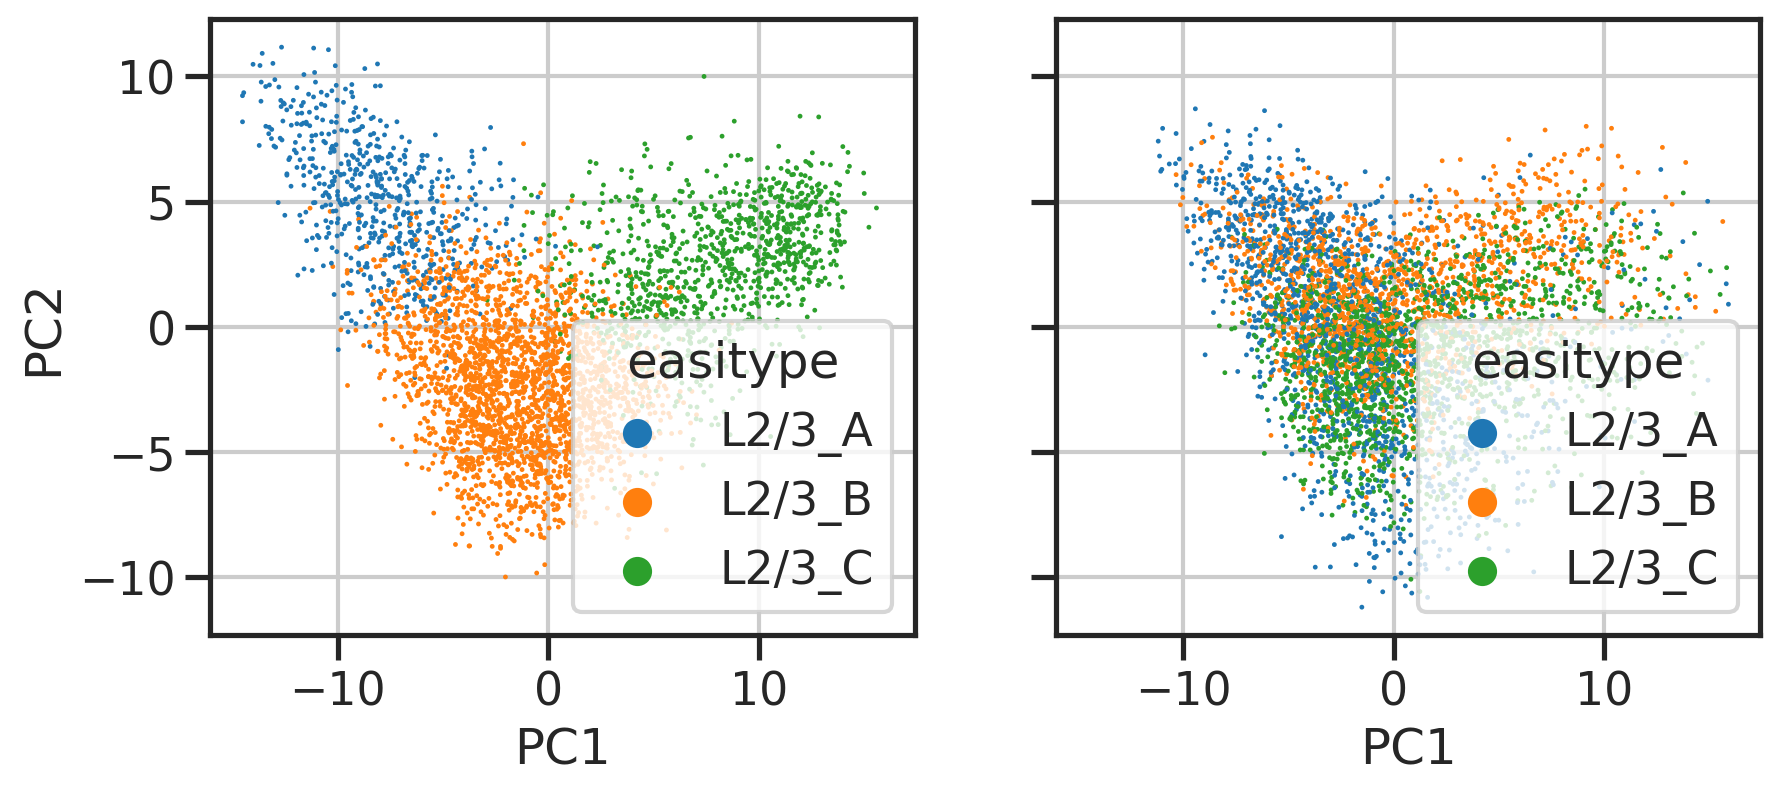

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
sns.scatterplot(data=df_nr, x='PC1', y='PC2', hue='easitype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
ax = axs[1]
sns.scatterplot(data=df_dr, x='PC1', y='PC2', hue='easitype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
plt.show()

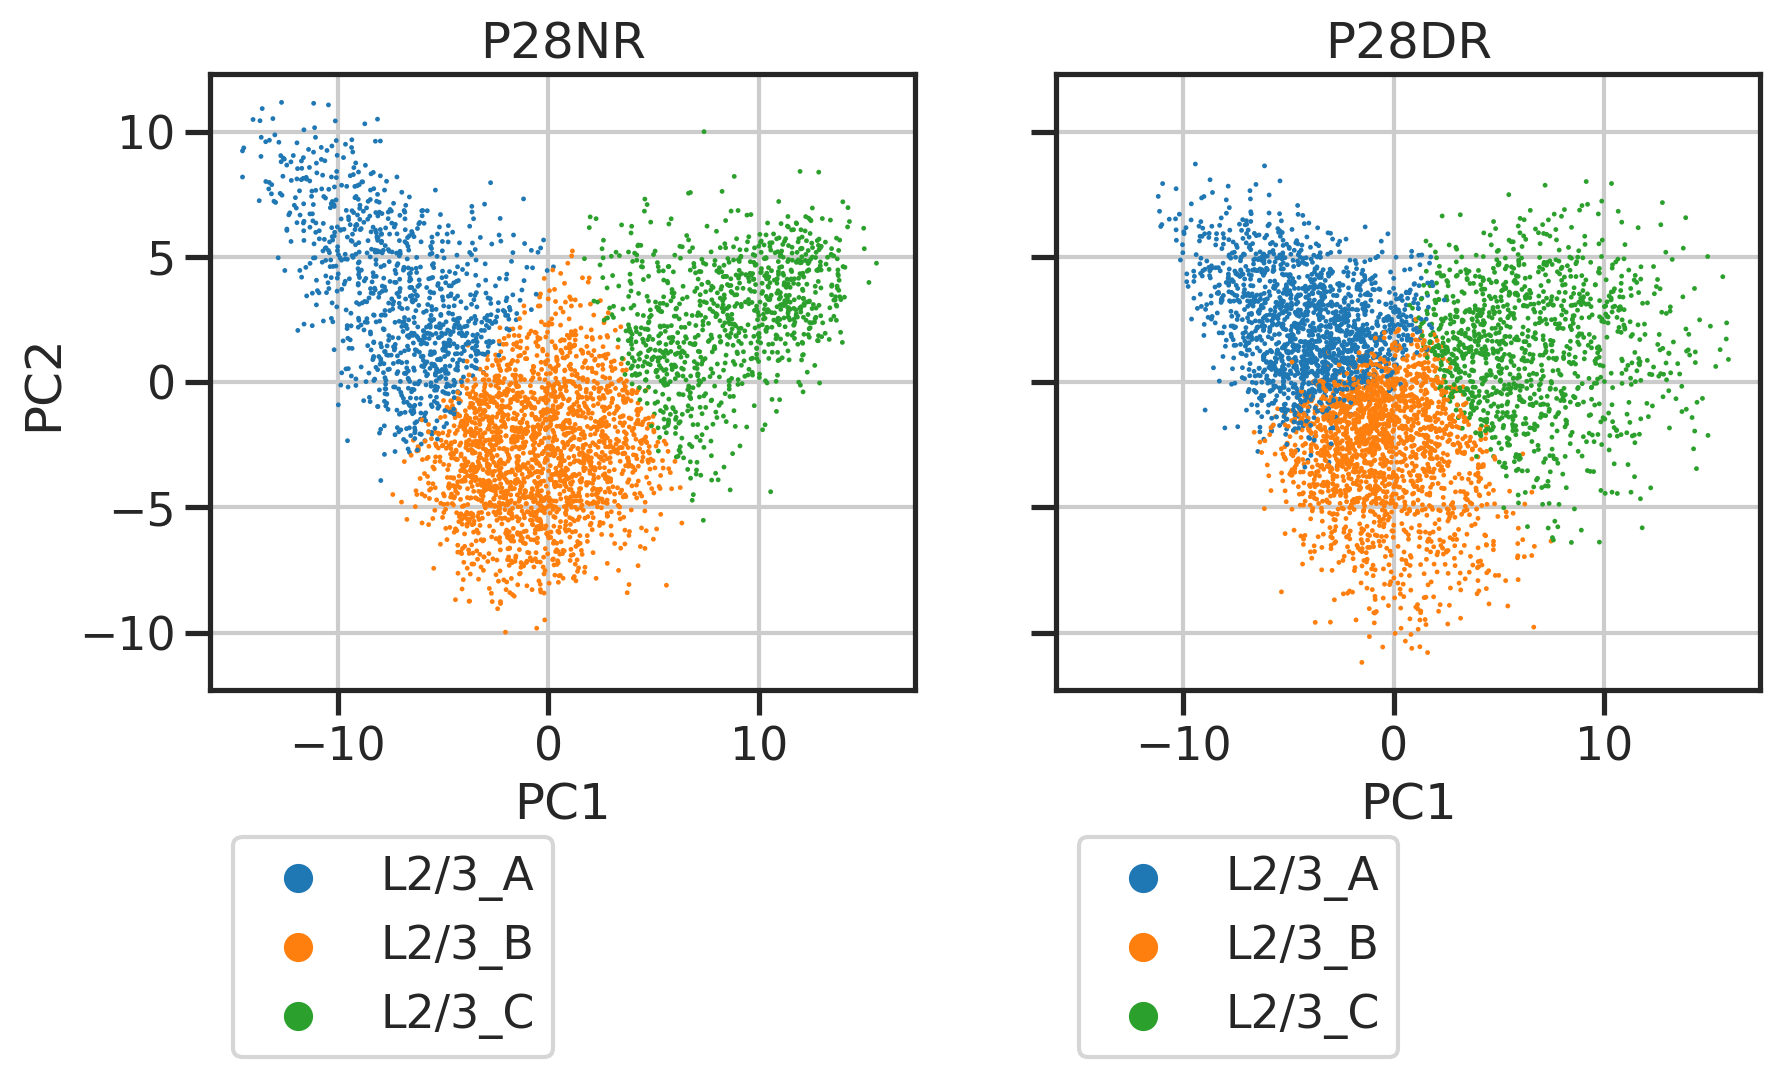

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
sns.scatterplot(data=df_nr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28NR')

ax = axs[1]
sns.scatterplot(data=df_dr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28DR')
plt.show()

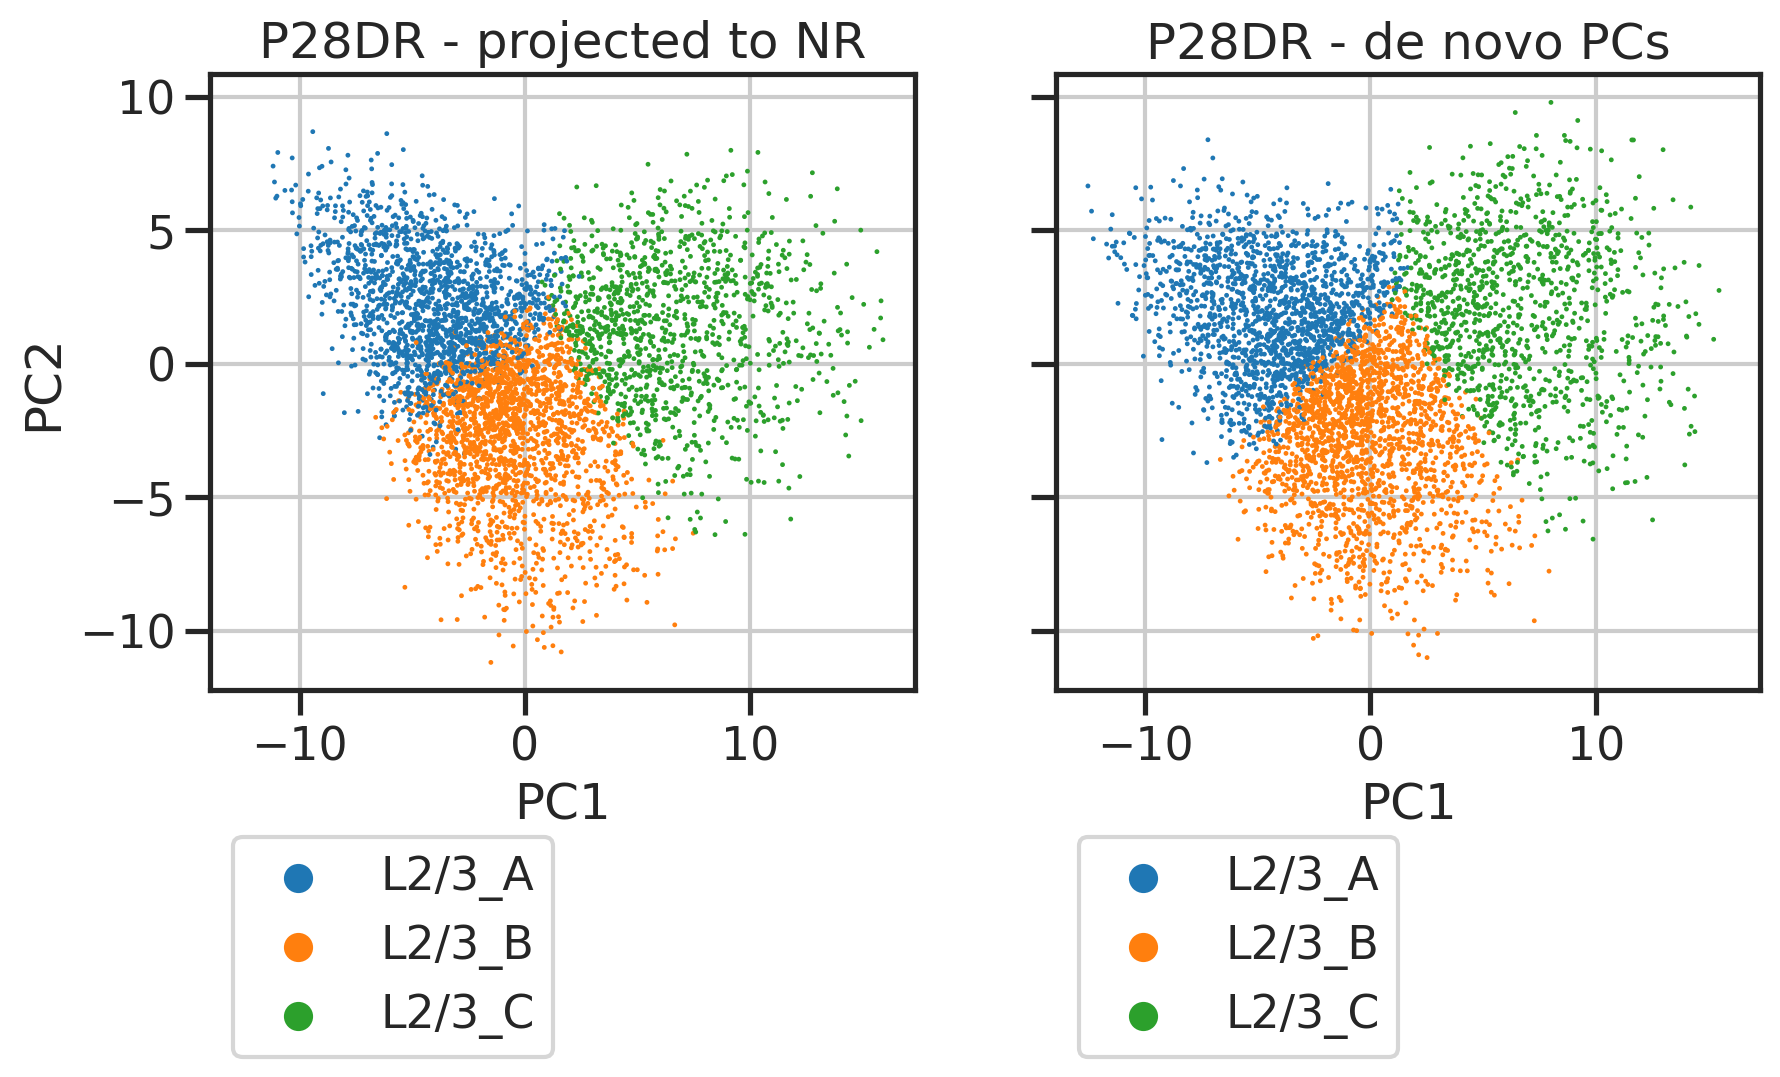

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
sns.scatterplot(data=df_dr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28DR - projected to NR')

ax = axs[1]
df_plot = df_dr2.copy()
df_plot['PC2'] = -df_plot['PC2'] 
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28DR - de novo PCs')
plt.show()

/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/u/home/f/f7xiesnm/.conda/envs/napari/lib/python3.9/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


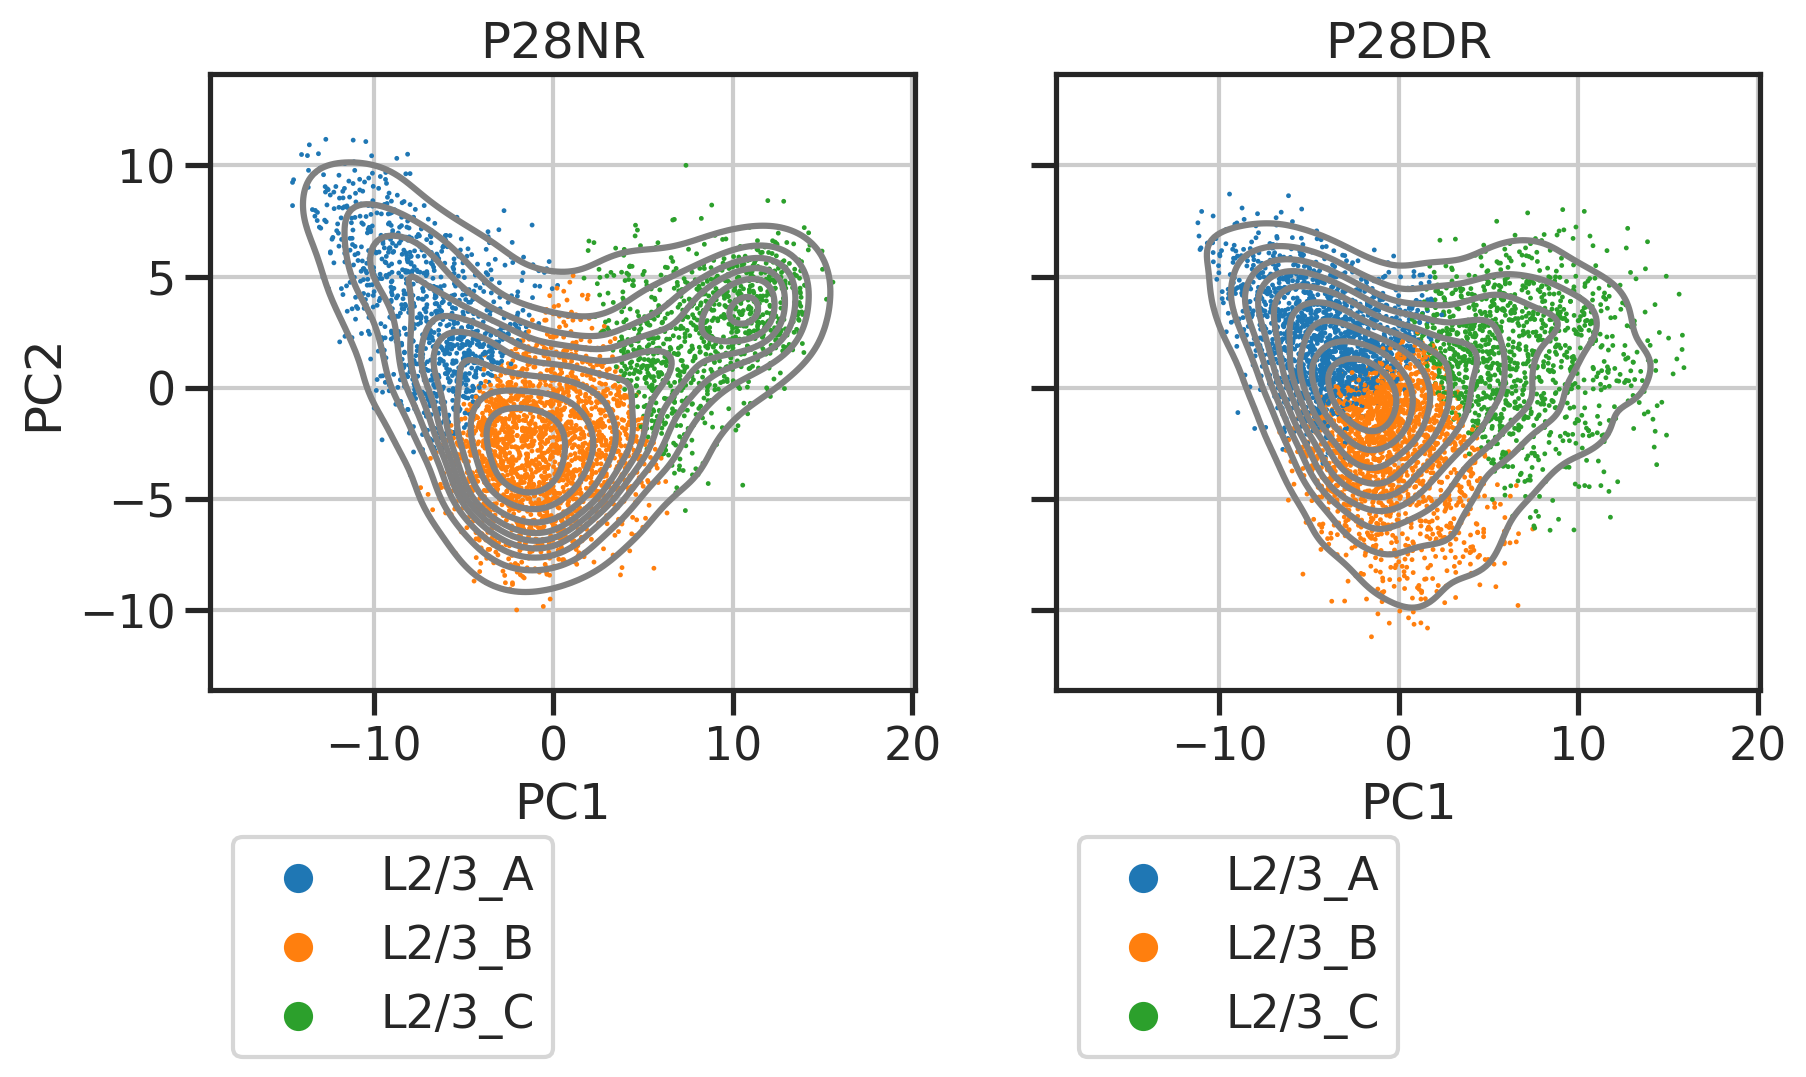

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
sns.scatterplot(data=df_nr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
sns.kdeplot(data=df_nr, x='PC1', y='PC2', color='gray', linewidth=1, zorder=2, ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28NR')

ax = axs[1]
sns.scatterplot(data=df_dr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
sns.kdeplot(data=df_dr, x='PC1', y='PC2', color='gray', linewidth=1, zorder=2, ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28DR')
plt.show()

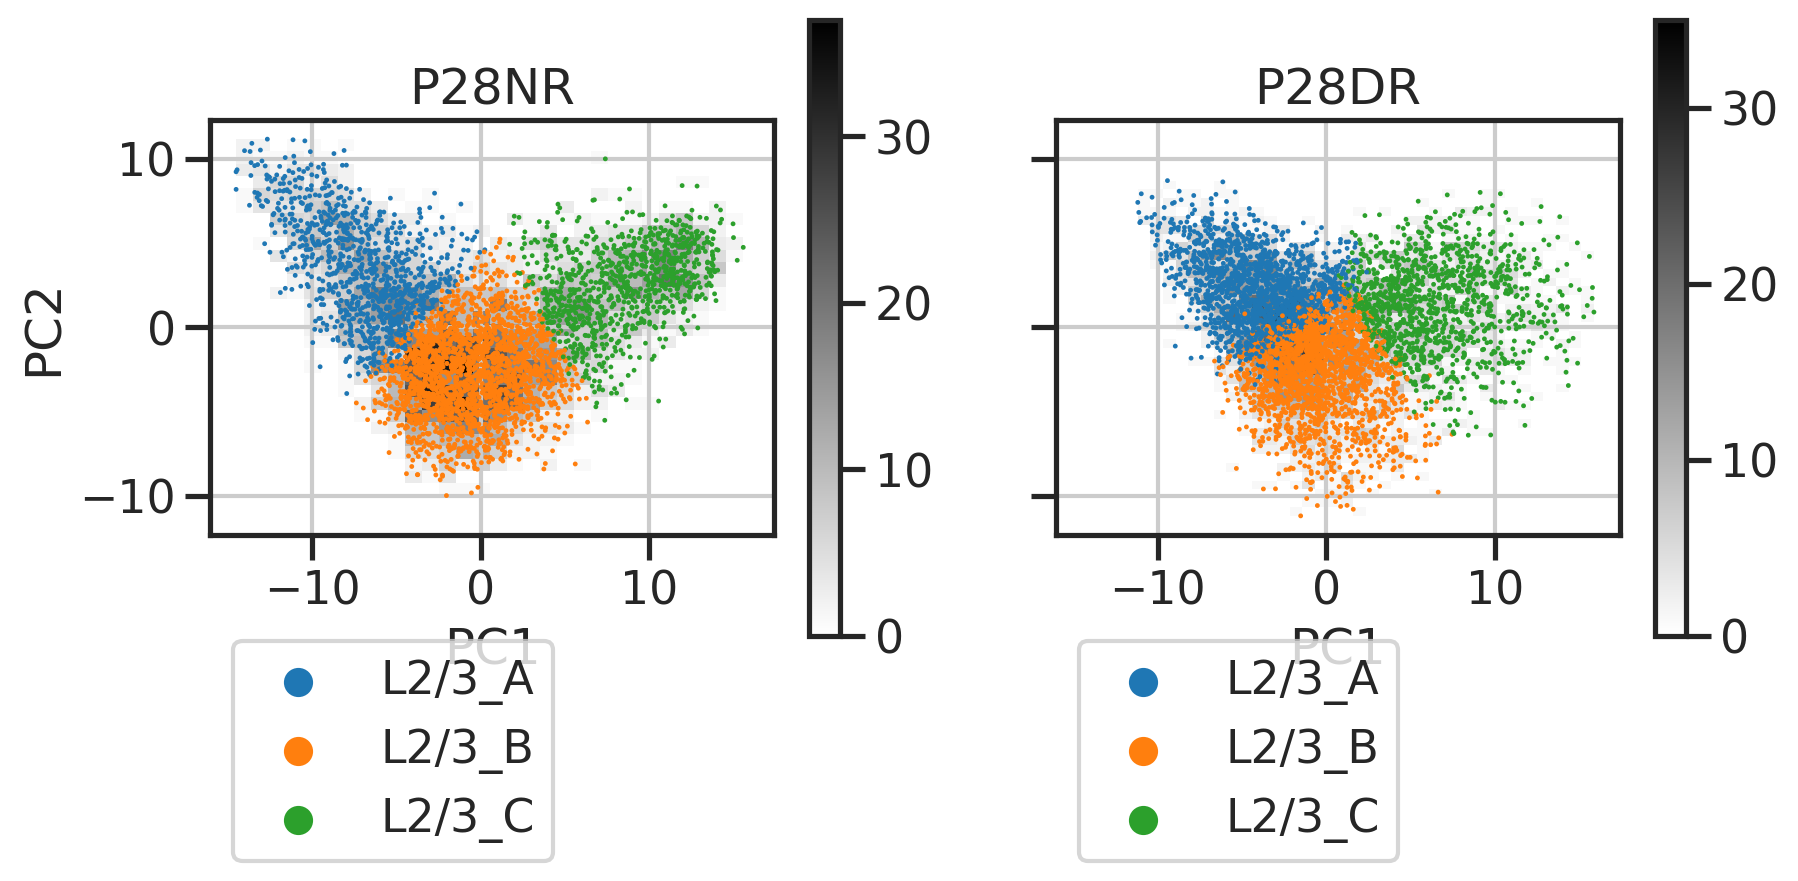

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(2*5,1*4), sharex=True, sharey=True)
ax = axs[0]
sns.scatterplot(data=df_nr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
sns.histplot(data=df_nr, x='PC1', y='PC2', linewidth=1, zorder=0, cmap='gray_r', cbar=True, ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28NR')
ax.set_aspect('equal')

ax = axs[1]
sns.scatterplot(data=df_dr, x='PC1', y='PC2', hue='newtype', s=3, edgecolor='none', palette=palette_type, hue_order=list(palette_type), ax=ax)
sns.histplot(data=df_dr, x='PC1', y='PC2', linewidth=1, zorder=0, cmap='gray_r', cbar=True, ax=ax)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_title('P28DR')
ax.set_aspect('equal')
plt.show()